# 1. General

<div class="alert alert-block alert-warning">
    <span style='font-family:Georgia'>

In this Section, we load the libraries. Also, we define some helpful functions to be utilized in the project.
    </ol>          
</div>


# 1.1 Load Libraries

In [1]:
#Data Structuring libraries
import numpy as np
import pandas as pd

#Data Preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import KNNImputer


# Data Analysis / Plotting
import matplotlib.pyplot as plt
import seaborn as sb
import missingno as msng

## 1.2 General Helper Functions

In [2]:
def print_shape(X):
    """
    Prints the shape of a pandas dataframe
   
       Parameters:
           
            X (Pandas.Dataframe) : The pandas dataframe under examination
       Returns:
           None
   
    """        
    if type(X) == pd.core.series.Series:
        print ("The",X.name ,"series"+" has",X.shape[0]," rows")  
        
    elif type(X) == pd.core.frame.DataFrame:
    
        print ("The",X.name ,"dataframe"+" has",X.shape[0]," rows and",X.shape[1] ,"columns" ) 
        
    return None

In [3]:
def print_df(df:'Pandas.DataFrame',n = 5, max_col = None , max_rows = None , random = True, flatten_col = False):
    """
    Prints some instances of a pandas dataframe
   
       Parameters:
           
            df (Pandas.Dataframe) : The pandas dataframe under examination
            n (int): number of rows to print
            max_col(int): maximum number of columns to print. If None, all the columns will be printed
            max_rows(int): maximum number of rows to print. If None, all the rows will be printed
            random (Bool): If True, random n samples will be printed
            flatten_col:(Bool): If True, all the cell content will be printed
            
       Returns:
           None
   
    """ 
    
    
    
    #setting the maximum number of columns and rows to be printed
    pd.set_option( "display.max_columns", max_col, "display.max_rows", max_rows)
    if flatten_col:
        pd.set_option( "display.max_colwidth", None) 
    
    #Sampling an n random rows from the dataframe to be displayed
    if random: 
        row_indices = np.random.randint(0,df.shape[0],n)
    elif random == False:
        row_indices= range(0,n)
    
    #printing the dataframe
    print("\033[1m The", df.name,"dataframe:" )
    display(df.iloc[row_indices,:])
    
    return None


In [4]:
def list_missingness(df:'Pandas.DataFrame' , only_missing = False):
    """
    prints the missingness percentage in each column of the df dataframe
   
       Parameters:
           
           df (Pandas.Dataframe) : The pandas dataframe under examination
           only_missing(Boolean): If True, only columns with non zero missingness will be printed.
       Returns:
           df is cleaned in place
   
    """
    
    
    
    data_nan = df.isnull().sum(axis = 0).sort_values(ascending = False)
    
    if only_missing:
        data_nan = data_nan.loc[data_nan!=0] 
    
    data_nan_perc = (data_nan /df.shape[0])*100
    
    return data_nan_perc


In [5]:
def Remove_Duplicated (df:'Pandas.DataFrame'):
    """
    Remove duplicated rows in a Pandas Dataframe and the relevant label series
   
       Parameters:
           
           df (Pandas.Dataframe) : The pandas dataframe 
       Returns:
           df is cleaned in place
   
    """
    #find indexes of the 2nd duplicate of rows
    dub = df.duplicated() 
    count = dub.sum()
    dub_mask = (dub == True)
    dub_idx = df[dub_mask].index
    #drop one of the duplicated rows from df 
    df.drop(labels = dub_idx , axis = 'index', inplace = True)   
    
    #reset the indexes of X and y (0,1,2,3,4,...., n_new)
    df.reset_index(inplace  = True,  drop = True)
    
    print (count,"duplicated rows were deleted from the",df.name,"dataset")
    return None
    

In [6]:
def plot_multi_dist(df:'Pandas DataFrame'):
    
    """
   Plots the first subset of an Image dataset
   
       Parameters:
           
           df (Pandas.Dataframe) : The pandas dataframe containing continuous variables 
       
       Returns:
           a matplotlib figure showing the distribution of all variables in df
   
    """
    n_images = df.shape[1]
    plt.figure(figsize = (20,40), layout = 'constrained' )
    for i in range(n_images):
        col = df.columns.values[i]
        mean = df.loc[:,col].mean()
        #plt.subplot(int(df.shape[1]/3),3,i+1)
        plt.subplot(round(df.shape[1]/3),3,i+1)
        plt.title(col)
        sb.kdeplot(df.loc[:,col],common_norm = True) 
        plt.axvline(mean, c='red')
        
    return None

In [7]:
def check_encoding (df:'Pandas DataFrame', first_col: 'str',second_col: 'str'):
    """
    States/prints if the first_col in df is the encoding of the second_col
   
       Parameters:
           
           df (Pandas.Dataframe) : The pandas dataframe containing continuous variables
           first_col (str) : The name of the first column to be examined
           second_col (str) : The name of the second column to be examined           
       
       Returns: None
    """
   
    
    #group the data by values in "eav_code", then checking the
    #uniqueness of 'types_of_waste' values for each 'eav_code' value
    unique_code_no = pd.Series(df.groupby([first_col])[second_col].nunique())

    #if each unique value in "eav_code" has only one corresponding unique value in 'types_of_waste',
    # then both columns are identical
    not_identical = (unique_code_no != 1).any()
    
    if not_identical:
        print("The "+str(first_col)+
              " variable is not the encoding/identical to the "+str(second_col)+" variable")
    else:
        print("The "+str(first_col)+
              " variable is the encoding/identical to the "+str(second_col)+" variable")   
        
    return None    

In [8]:
def get_categorical_continuous (df:'Pandas.DataFrame'):
    """
   Identifies categorical variables and continuous variables in a pandas dataframe
   
       Parameters:
               
           X (Pandas.Dataframe) : The pandas dataframe containing mixed varaibles (continuous and Categorical)
       
       Returns:
           categorical (list) : A list of all categorical variables
           continuous (list) : A list of all continuous variables

    """   
    
    #identifying columns that have boolean entries (one-class categorical)
    boolean_vars = [i for i in df if 
                    df[i].dropna().value_counts().index.isin([0,1]).all()]
    #identifying columns that have object entries (multi--class categorical)
    categorical = [i for i in df.select_dtypes(include=object)]
    #adding all categorical columns name together
    categorical.extend(boolean_vars)


    #identifying columns that have numerical entries
    continuous = [i for i in df.select_dtypes(exclude =object)]
    #exclude numerical columns that have one-class labels
    continuous = list(filter(lambda x: x not in boolean_vars, continuous))
    
    return (categorical,continuous)

In [9]:
def one_hot_encoder(X:'Pandas DataFrame'):
    """
    Encodes categorical variables in a pandas dataframe using One-Hot-Encoding
   
       Parameters:
           
           X (Pandas.Dataframe) : The pandas dataframe containing mixed varaibles (continuous and Categorical)
       
       Returns:
           X_encoded (Pandas.Dataframe) : The pandas dataframe containing the continuous variables of X along 
                                          with one-hot encoded categorical variables 
    """           
    # listing categorical variables and continuous variables each separately
    categorical_all,continuous_all = get_categorical_continuous(X)
    # one-hot-encoding of the categorical variables
    cat_dummies = pd.get_dummies(X[categorical_all])
    X_encoded= pd.concat([X[continuous_all], cat_dummies], axis = 1)
    X_encoded.name = str(X.name)+'_encoded'
 
    return X_encoded

# 2. Data Preprocessing/Cleaning 

<div class="alert alert-block alert-warning">
    <span style='font-family:Georgia'>

In this Section, We clean the data and preprocess it for the purpose of analysis and training
    </ol>          
</div>


## 2.1 Loading the Dataset

In [10]:
# Loading the three CSV files
waste_generated = pd.read_csv("waste_generated_32161-0001.csv", sep = ',', encoding = 'CP1252')


In [11]:
#Naming the data frame so that they be compatible with helper functions
waste_generated.name = "waste_generated"


## 2.2 Initial Exploratory Data Analysis

##### In this subsection, we do some  preliminary data analysis to know more about the dataset's structure

### 2.2.1 Printing the shape of each dataframe:

In [12]:
print_shape(waste_generated)

The waste_generated dataframe has 2726  rows and 6 columns


### 2.2.2 Displaying Data in a tabulated form

##### Printing the applciation data

In [13]:
print_df (df = waste_generated, n = 10, flatten_col = True)

 The waste_generated dataframe:


,year,data_belong_to,eav_code,types_of_waste,etroi_establishments_number,generated_waste_quantity
199,2010,Germany as a whole,EAV-070213-U,plastic bags,1299.0,327.9
1578,2014,Germany as a whole,EAV-160902-G,Chromates (potassium chromate potassium or sodium dichromates),NaN,NaN
405,2010,Germany as a whole,EAV-100808-G,Non-ferrous metal: salt slags (first sweet melt),NaN,NaN
915,2014,Germany as a whole,EAV-010307-G,Cases from processing metallized earthenware,NaN,NaN
778,2010,Germany as a whole,EAV-190603-U,Fluids from the treatment of collapsed lungs,NaN,NaN
2302,2018,Germany as a whole,EAV-101401-G,Crematorium: mercury h. Waste gas cleaning,3.0,0.0
984,2014,Germany as a whole,EAV-030302-U,Sulphite lamb (from recovery of coal gas),NaN,NaN
2359,2018,Germany as a whole,EAV-130109-G,Chlorinated hydraulics on mineral oil basis,3.0,0.0
2708,2018,Germany as a whole,EAV-200141-U,Waste from the cleaning of hornstones,NaN,NaN
361,2010,Germany as a whole,EAV-100326-U,Slurries and filter cakes from exhaust gas treatment (oh.100325),NaN,NaN


In [14]:
waste_generated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2726 entries, 0 to 2725
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year                         2726 non-null   int64  
 1   data_belong_to               2726 non-null   object 
 2   eav_code                     2726 non-null   object 
 3   types_of_waste               2726 non-null   object 
 4   etroi_establishments_number  2072 non-null   float64
 5   generated_waste_quantity     2072 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 127.9+ KB


<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Comment: </b><br>
<li> The data has missing values in some entries (NaN) in the (etroi_establishments_number and generated_waste_quantity) columns.
<li> The data has 4 categorical variables (year , data_belong_to, eav_code, types_of_waste).
<li> The data has 2 continuous variables (etroi_establishments_number, generated_waste_quantity).
<li> The meanign of the "eav_code" variable is unknown, but we suspect that it may be unique for each waste type.  


</div>

<div class="alert alert-block alert-success">
    <span style='font-family:Georgia'>
        <b>Action: </b><br>
<li> "year" variable will be treated as an ordinary categorical variable. This way, it will be meaningful during predictions.
<li> The variable eav_code shall be examined if it is unique for each value in types_of_waste or not.
<li> The variables (eav_code, types_of_waste) shall be checked for having unique values or not.
<li> Missing values shall be imputed.    
</div>


##### Checking if eav_code is encoding of types_of_waste

In [15]:
check_encoding(waste_generated, first_col ='eav_code' , second_col ='types_of_waste')

The eav_code variable is the encoding/identical to the types_of_waste variable


<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Comment: </b><br>
<li> The 'eav_code' variable is the encoding of the 'types_of_waste' variable.
</div>

<div class="alert alert-block alert-success">
    <span style='font-family:Georgia'>
        <b>Action: </b><br>
<li> The "eav_code" variable will be dropped from the data, but will be kept in a series form for viasualization purposes.
</div>


##### Dropping the eav_code variable

In [16]:
waste_type_encoded = waste_generated["eav_code"]
waste_generated.drop(columns = ["eav_code"], inplace = True)

##### Description of the categorical variables:

In [17]:
waste_generated.describe(include = 'object')

,data_belong_to,types_of_waste
count,2726,2726
unique,1,902
top,Germany as a whole,Waste (esp. requirement from infection prevention sight)
freq,2726,6


<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Comment: </b><br>
<li> The "year" variable has only three years.
<li> The "data_belong_to" variable has only one class, which is "Germany as a whole". This means that the variable is useless in prediction and doesn't give intuition of any patterns.
<li> The (eav_code, types_of_waste) variables has 909 and 902 classess respectively.
</div>

<div class="alert alert-block alert-success">
    <span style='font-family:Georgia'>
        <b>Action: </b><br>
<li> The "data_belong_to" variable will be dropped.
</div>


##### Description of the Continuous variables:

In [18]:
waste_generated.describe()

,year,etroi_establishments_number,generated_waste_quantity
count,2726.000000,2072.000000,2072.000000
mean,2013.998533,351.043919,95.528620
std,3.266286,1164.442500,362.738412
min,2010.000000,3.000000,0.000000
25%,2010.000000,9.000000,0.700000
50%,2014.000000,35.000000,4.700000
75%,2018.000000,153.000000,33.025000
max,2018.000000,13961.000000,5384.900000


<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Comment: </b><br>
<li> both variables have no negative values (which is good; since negative values will be wrong).
</div>



##### Dropping the year variable

In [19]:
waste_generated.drop(columns = ["data_belong_to"], inplace = True)

## 2.3  Duplicated rows removal

##### In this subsection, we remove all the duplicated rows

In [20]:
Remove_Duplicated(waste_generated)

0 duplicated rows were deleted from the waste_generated dataset


## 2.4  Missing Values Treatment 

### 2.4.1  Missing Values Analysis

##### Calculating the percantage of missing values (NAN) in each variable:

In [21]:
nan_perc = list_missingness(waste_generated, only_missing = True)
print("The percentage of missing entries per each of the variables is:")
display(nan_perc)

The percentage of missing entries per each of the variables is:


etroi_establishments_number    23.991196
generated_waste_quantity       23.991196
dtype: float64

<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Comment: </b><br>
<li> Both variables have the same percentage of missingness.
</div>

<div class="alert alert-block alert-success">
    <span style='font-family:Georgia'>
        <b>Action: </b><br>
<li> Missingness patterns between missing values in both variables will be checked.  
</div>


#####  Plotting the heat map for missingness:

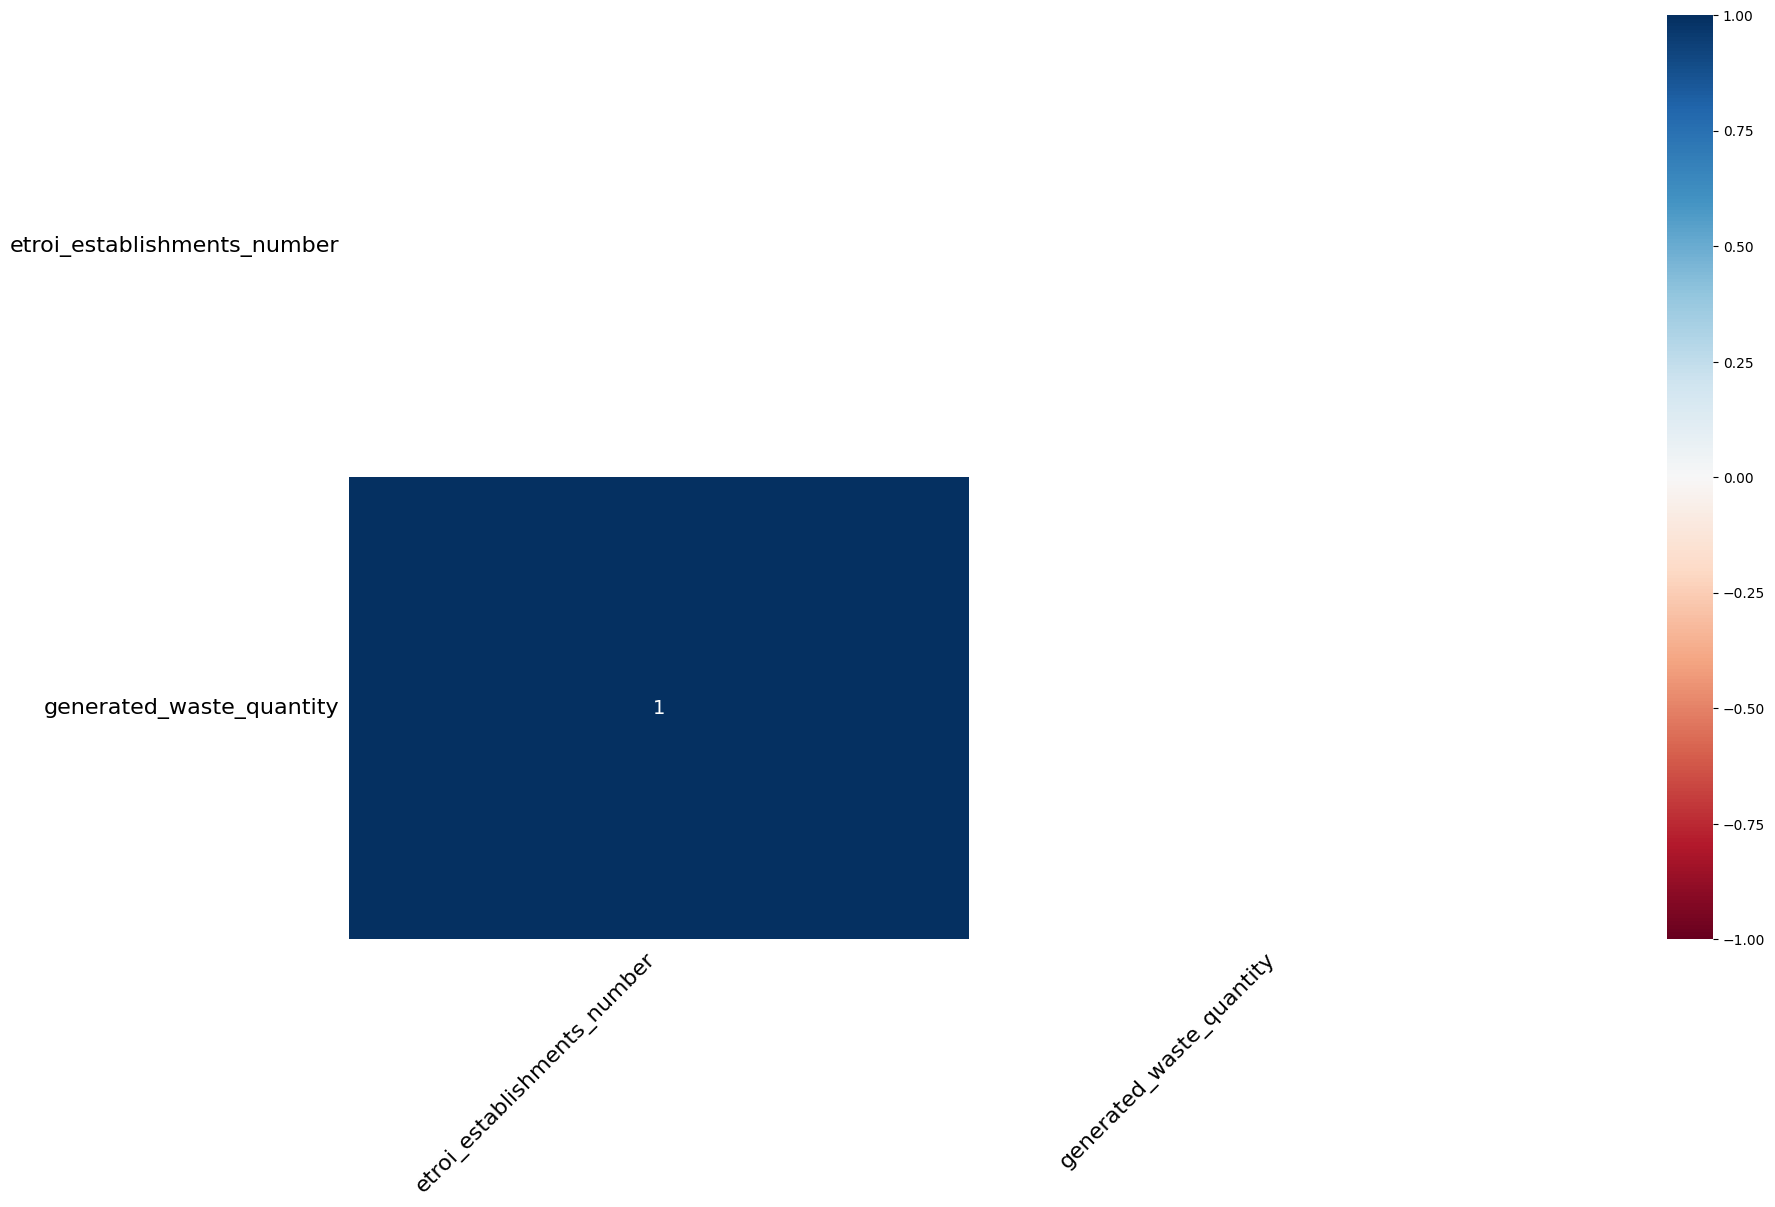

In [22]:
msng.heatmap(waste_generated);

<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Comment: </b><br>
<li> Missingness of the "etroi_establishments_number" variable is totally correlated with missingess of the "generated_waste_quantity" variable.
 This means that whenever one of them is missing, the other is missing.
<li> Since the missingness of a variable is related to the missingness of another, The missingness cannot be classified as missing completely at random (MCAR).
</div>    
<div class="alert alert-block alert-success">
    <span style='font-family:Georgia'>
        <b>Action: </b><br>
<li> We shall check if the missingness is missing at random (MAR) or missing not at random (MNAR).
</div>    
    

##### Checking if missingness is related to the value of nonmissing variables:

In [23]:
#check if missingness is associated to one specific year
waste_generated.groupby(["year"], dropna = False)["etroi_establishments_number"].apply(lambda x: x.isna().sum())


year
2010    205
2014    215
2018    234
Name: etroi_establishments_number, dtype: int64

In [24]:
#checking if missingness is associated to one specific waste type
(waste_generated.groupby(["types_of_waste"], dropna = False)["etroi_establishments_number"].apply(lambda x: x.isna().sum()))


types_of_waste
 Abrasive waste (excluding 120116)                                                     0
 Abrasive waste (with dangerous substances)                                            0
 Absences and nothing differentiable                                                   3
 Absences from the exhaust gas treatment with danger. St.                              0
 Acid forming treatment residues a. sul. ore                                           3
 Acid: Waste nec                                                                       0
 Activated charcoal from Chlorhersthaling                                              2
 Adhesive and dense mass hold. Muds(oh.080411)                                         0
 Adhesive and sealant cases with ear. St.                                              0
 Adhesive and sealant waste (oh 080409)                                                0
 Adhesive sealant: Aqueous sludge with hazardous level                                 0
 Adhes

<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Comment: </b><br>
<li> After examination, missingness is not associated to any specific value in the nonmissing columns.
<li> This means that the missing data cannot be classified as missing at random (MAR).
<li> Since the missingness is not MCAR or MAR, it is MNAR.    

### 2.4.2  Missing Values Imputation

<div class="alert alert-block alert-warning">
    <span style='font-family:Georgia'>
        <b>Strategy: </b><br>
<li> Since the missing data is not classified as (MCAR), we will not impute the data using pairwise deletion (delete variables)
nor listwise deletion(delete instances). 
<li> Also we will not impute the data using mean imputation because it's known that the distribution mean suffers from a drastic change when there are data missing not at random (MNAR).
<li> We will use KNN Imputation method since it is known to give good results. 
 

In [25]:
# encoding categorical variables
waste_generated_encoded = one_hot_encoder(waste_generated)


In [26]:
#imputing missing values using KNN Imputation
imputer = KNNImputer(n_neighbors=1) # n_neighbors=1 because etroi_... is integer not float
waste_generated_imputed = imputer.fit_transform(waste_generated_encoded)
waste_generated_imputed = pd.DataFrame(waste_generated_imputed,columns = waste_generated_encoded.columns)

In [27]:
#add imputed data to the original data
waste_generated.loc[:, ['etroi_establishments_number', 'generated_waste_quantity']] = waste_generated_imputed.loc[:, ['etroi_establishments_number', 'generated_waste_quantity']]

# 3 Exploratory Data Analysis

##### Visualizaiton of the top 20 waste types over the whole dataset

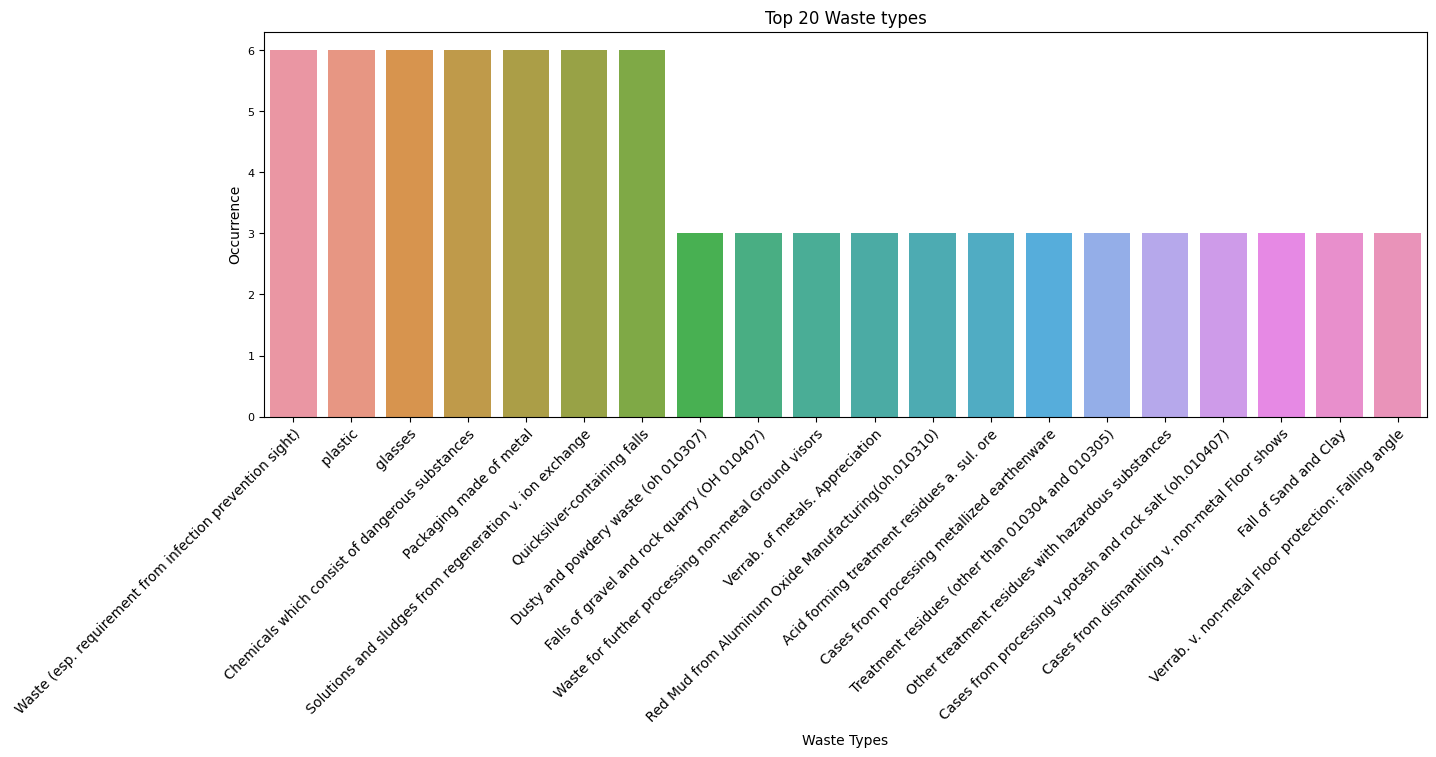

In [28]:
n= 20
top_n_Waste = waste_generated['types_of_waste'].value_counts().sort_values(ascending=False)[:n].reset_index()
fig = plt.figure(figsize=(15,5))
ax = sb.barplot(x = top_n_Waste['types_of_waste'], y = top_n_Waste['count'])
plt.yticks(fontsize=8)
plt.xticks (rotation =45,fontsize =10, rotation_mode='anchor', ha='right')
plt.xlabel("Waste Types")

plt.ylabel("Occurrence")
plt.title("Top "+str(n)+" Waste types")
plt.show()

<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Comment: </b><br>
<li> the occurance of the top 20 waste type is very small (i.e the top occuring class occured 6 times only). This means that there are a lot of dfferent waste types and many of them may have been happened few times in the observed data.
<li> This may mean that this variable will be useless if used in prediction; since the new instance have a high probability of having a value other than the ones in the data (which the model has learned from). 

In [29]:
waste_generated["types_of_waste"].value_counts().describe()

count    902.000000
mean       3.022173
std        0.265594
min        2.000000
25%        3.000000
50%        3.000000
75%        3.000000
max        6.000000
Name: count, dtype: float64

##### Visualizaiton of the top 20 waste types for year 2010

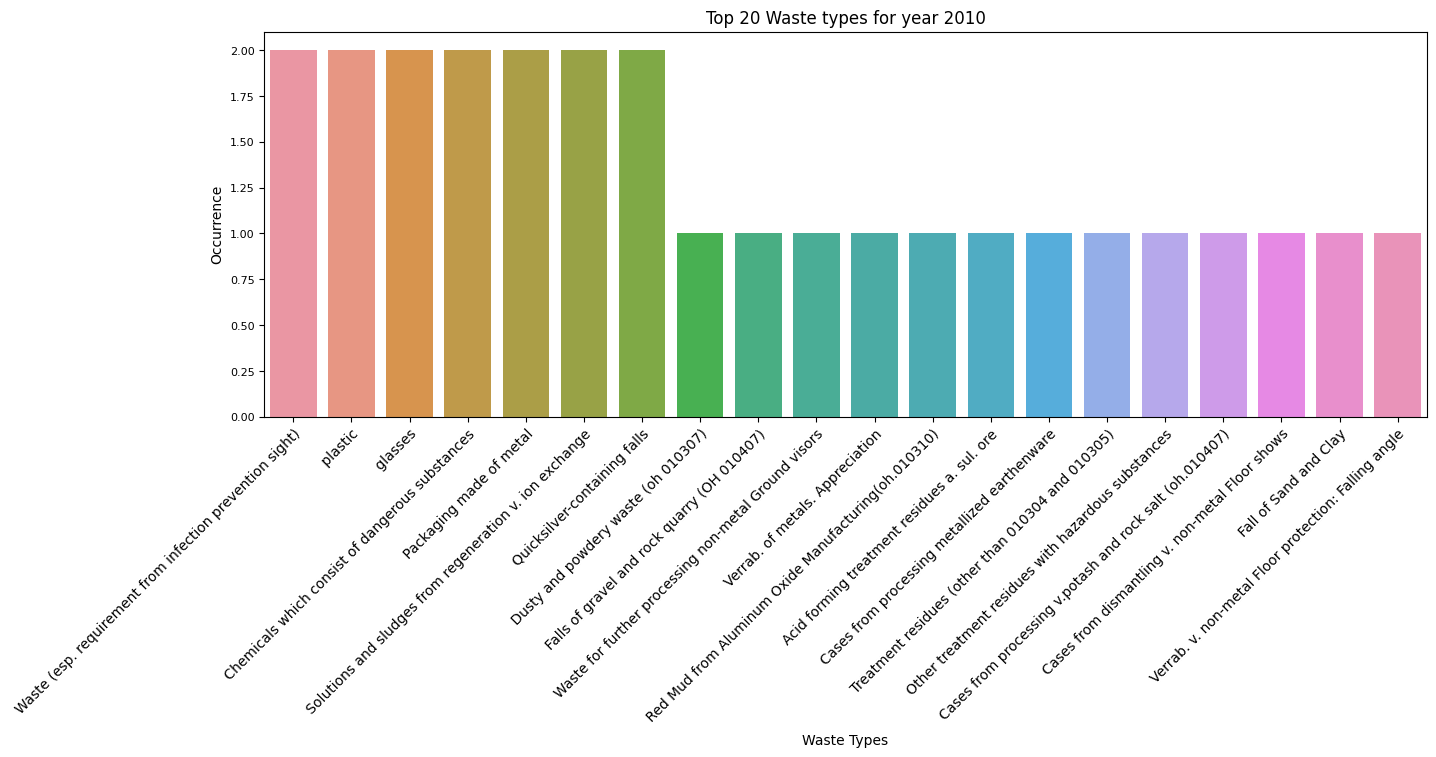

In [30]:
n= 20
year = 2010
waste_generated_year = waste_generated.loc[waste_generated["year"] == year]
top_n_Waste = waste_generated_year['types_of_waste'].value_counts().sort_values(ascending=False)[:n].reset_index()
fig = plt.figure(figsize=(15,5))
ax = sb.barplot(x = top_n_Waste['types_of_waste'], y = top_n_Waste['count'])
plt.yticks(fontsize=8)
plt.xticks (rotation =45,fontsize =10, rotation_mode='anchor', ha='right')
plt.xlabel("Waste Types")

plt.ylabel("Occurrence")
plt.title("Top "+str(n)+" Waste types for year "+ str(year))
plt.show()

##### Visualizaiton of the top 20 waste types for year 2014

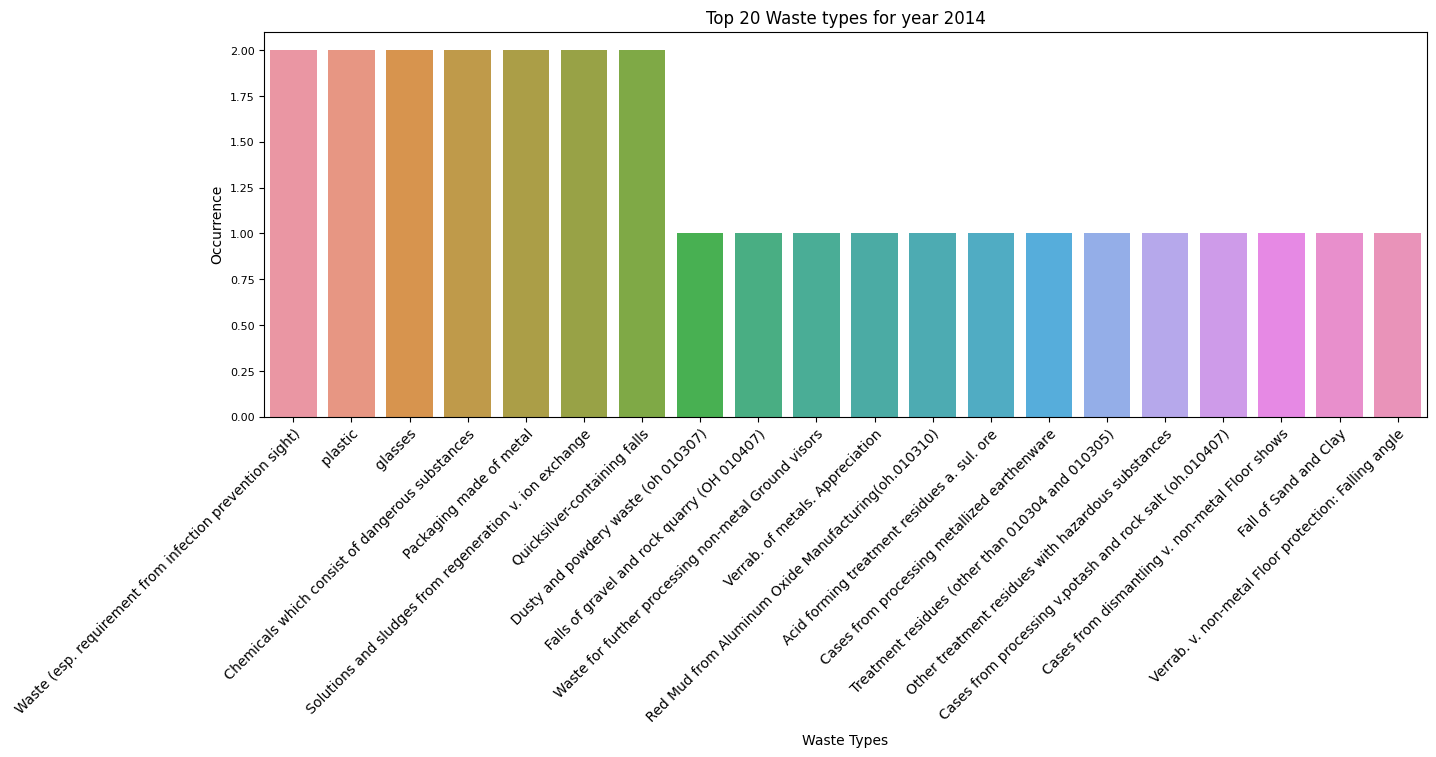

In [31]:
n= 20
year = 2014
waste_generated_year = waste_generated.loc[waste_generated["year"] == year]
top_n_Waste = waste_generated_year['types_of_waste'].value_counts().sort_values(ascending=False)[:n].reset_index()
fig = plt.figure(figsize=(15,5))
ax = sb.barplot(x = top_n_Waste['types_of_waste'], y = top_n_Waste['count'])
plt.yticks(fontsize=8)
plt.xticks (rotation =45,fontsize =10, rotation_mode='anchor', ha='right')
plt.xlabel("Waste Types")

plt.ylabel("Occurrence")
plt.title("Top "+str(n)+" Waste types for year "+ str(year))
plt.show()

##### Visualizaiton of the top 20 waste types for year 2018

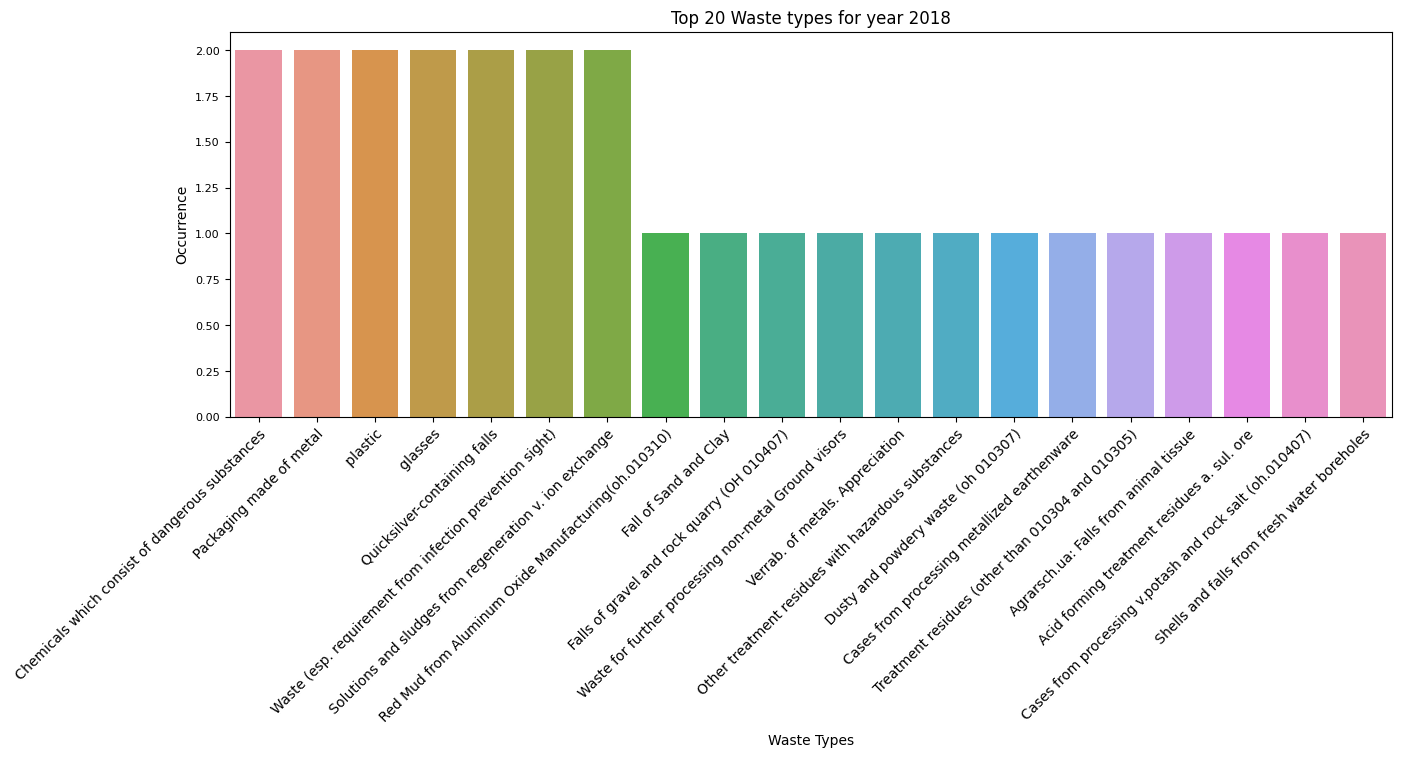

In [32]:
n= 20
year = 2018
waste_generated_year = waste_generated.loc[waste_generated["year"] == year]
top_n_Waste = waste_generated_year['types_of_waste'].value_counts().sort_values(ascending=False)[:n].reset_index()
fig = plt.figure(figsize=(15,5))
ax = sb.barplot(x = top_n_Waste['types_of_waste'], y = top_n_Waste['count'])
plt.yticks(fontsize=8)
plt.xticks (rotation =45,fontsize =10, rotation_mode='anchor', ha='right')
plt.xlabel("Waste Types")

plt.ylabel("Occurrence")
plt.title("Top "+str(n)+" Waste types for year "+ str(year))
plt.show()

<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Comment: </b><br>
<li> The order of the top occuring waste types has changed in 2018. But, this is a useless information since the maximum number of occurance is very small (6). 

##### Visualization of the distribution for the amount of generated waste

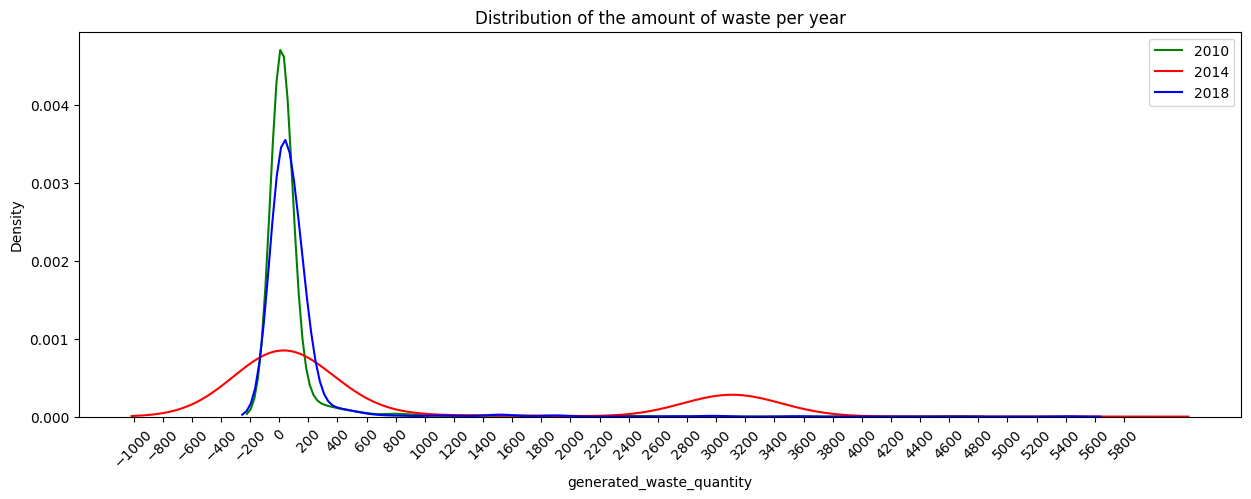

In [33]:
df = waste_generated.copy()
target = "year"
cont_var = "generated_waste_quantity"
target_classes = ("2010","2014","2018")


plt.figure(figsize=(15,5))

#Plotting the distribution of the waste amount in year = 2010
sb.kdeplot(df.loc[df[target] == 2010,cont_var],color="g", label = target_classes[0] )

#Plotting the distribution of the waste amount in year = 2014
sb.kdeplot(df.loc[df[target]==2014,cont_var], color="r",label = target_classes[1] )

#Plotting the distribution of the waste amount in year = 2018

sb.kdeplot(df.loc[df[target]==2018,cont_var], color="b",label = target_classes[2] )
plt.title("Distribution of the amount of waste per year")
plt.xticks(np.arange(-1000, 6000, 200), rotation = 45)

plt.legend()
plt.show()

<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Comment: </b><br>
<li> Most waste quantities for years 2010 and 2018 are less than 100.
<li> The year 2014 has waste amount in the range of 2000:4000

##### Visualization of the distribution for the "etroi_establishments_number"

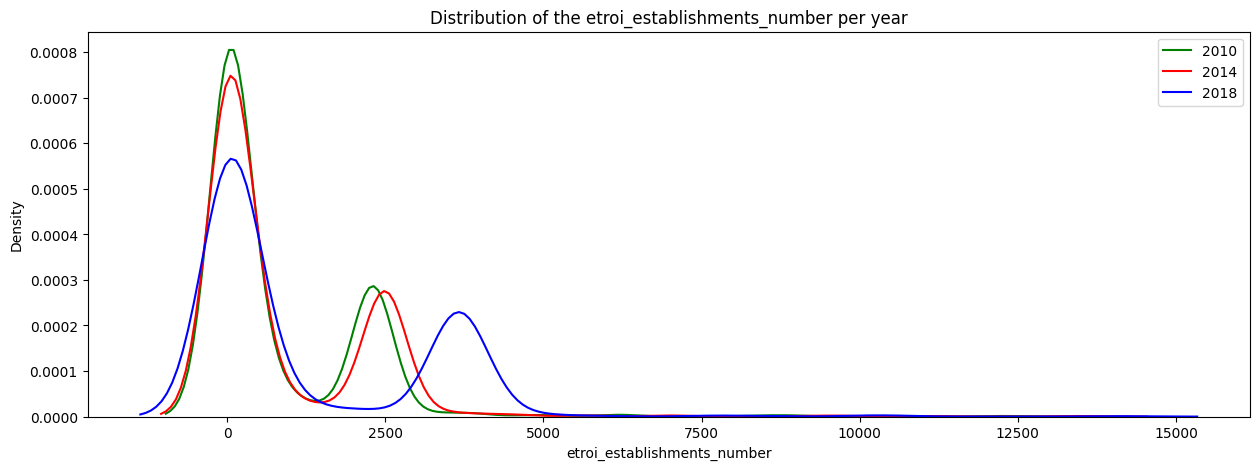

In [34]:
df = waste_generated.copy()
target = "year"
cont_var = "etroi_establishments_number"
target_classes = ("2010","2014","2018")


plt.figure(figsize=(15,5))

#Plotting the distribution of the waste amount in year = 2010
sb.kdeplot(df.loc[df[target] == 2010,cont_var],color="g", label = target_classes[0] )

#Plotting the distribution of the waste amount in year = 2014
sb.kdeplot(df.loc[df[target]==2014,cont_var], color="r",label = target_classes[1] )

#Plotting the distribution of the waste amount in year = 2018

sb.kdeplot(df.loc[df[target]==2018,cont_var], color="b",label = target_classes[2] )
plt.title("Distribution of the etroi_establishments_number per year")

plt.legend()
plt.show()

<div class="alert alert-block alert-info">
    <span style='font-family:Georgia'>
        <b>Comment: </b><br>
<li> the etroi_establishments_number has the same pattern in years 2010, 2014, and 2018